<a href="https://colab.research.google.com/github/surajsarkar/deepLearning/blob/main/notebooks/04_transfer_learning_introduction_feature_exrraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning**

In [ ]:
# which GPU are we using?

!nvidia-smi

Mon Jun 13 17:10:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Downliading and becoming one with the data**

In [ ]:
# Downloading the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the file 
import zipfile 

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-06-13 17:10:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  98.2MB/s    in 1.6s    

2022-06-13 17:10:09 (98.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



## **Inspact Data**

In [ ]:
import os

for dirpath, dirname, filename in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirname)} directories and {len(filename)} file in {dirpath}")

There are 2 directories and 0 file in 10_food_classes_10_percent
There are 10 directories and 0 file in 10_food_classes_10_percent/test
There are 0 directories and 250 file in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 file in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 file in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 file in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 file in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 file in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 file in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 file in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 file in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 file in 10_food_classes_10_percent/test/pizza
There are 10 directories and 0 file in 10_food

## **Creating data loaders (preparing the data)**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)

print("Traning Data:")
train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir,
                                                          target_size = IMAGE_SIZE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical",)

print("Testing Data:")
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMAGE_SIZE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Traning Data:
Found 750 images belonging to 10 classes.
Testing Data:
Found 2500 images belonging to 10 classes.


## **Setting up callback (things to run wilst our model trains)**

Callbacks are extra functionality which you can run to your models to performed during or after training. Some of the popular callbacks are: 

* Tracking experiments with TensorBoard Callback.
* Model checkpoint with ModelCheckpoint Callback.
* Stoping model from traning(before it trains too long and overfits) with EarlyStopping Callback.

In [ ]:
import tensorflow as tf

In [ ]:
# Create a tensorboard callback 

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%y%m%d-%H%M%S")

  tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorflow log file to {log_dir}")

  return tensorflow_callback

## **Creating model using Tensorflow Hub**

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
# Import Dependencies 
import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from url.
def create_model(model_url, num_classes=10):

  # Download the pretrained model and save it as a Keras layer 
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, # freeze the already trained pattern
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SIZE + (3,))
  
  # Create our own model 
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  
  return model

### **Creating and testing ResNet Tesnsorflow Hub Feature Extraction Model**

In [ ]:
# Creating a resnet model 
resnet_model = create_model(model_url = resnet_url, num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model 
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# Fit a model 
history_resnet = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback("tensorflow_hub", "resnet50V2")])

Saving Tensorflow log file to tensorflow_hub/resnet50V2/220613-171026
Epoch 1/5
24/24 [==============================] - 32s 742ms/step - loss: 1.9062 - accuracy: 0.3840 - val_loss: 1.2153 - val_accuracy: 0.6272
Epoch 2/5
24/24 [==============================] - 16s 694ms/step - loss: 0.9217 - accuracy: 0.7333 - val_loss: 0.8274 - val_accuracy: 0.7372
Epoch 3/5
24/24 [==============================] - 15s 661ms/step - loss: 0.6308 - accuracy: 0.8200 - val_loss: 0.7628 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 15s 664ms/step - loss: 0.4851 - accuracy: 0.8813 - val_loss: 0.7075 - val_accuracy: 0.7600
Epoch 5/5
24/24 [==============================] - 16s 666ms/step - loss: 0.3886 - accuracy: 0.9120 - val_loss: 0.6702 - val_accuracy: 0.7744


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
import pandas as pd

pd.DataFrame(history_resnet.history)

,loss,accuracy,val_loss,val_accuracy
0,1.906208,0.384000,1.215304,0.6272
1,0.921738,0.733333,0.827403,0.7372
2,0.630813,0.820000,0.762832,0.7544
3,0.485091,0.881333,0.707515,0.7600
4,0.388591,0.912000,0.670174,0.7744


In [ ]:
pd.DataFrame(history_resnet.history["loss"]).shape

(5, 1)

In [ ]:
type(history_resnet)

keras.callbacks.History

In [ ]:
# Let's create a function to create our loss curve.
import pandas as pd 
import matplotlib.pyplot as plt

def plot_history(history):
  """
  Args:
    history (type: keras.callbacks.History) -> Which you want to plot.
  """
  history_data = history.history
  # Taking each column
  loss = history_data["loss"]
  val_loss = history_data["val_loss"]

  accuracy = history_data["accuracy"]
  val_accuracy = history_data["val_accuracy"]

  epochs = range(len(loss))

  # Plotting accuracy
  plt.figure(figsize = (10, 7))
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.legend()

  # plotting loss
  plt.figure(figsize = (10, 7))
  plt.plot(epochs, loss, label='loss')
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.legend()


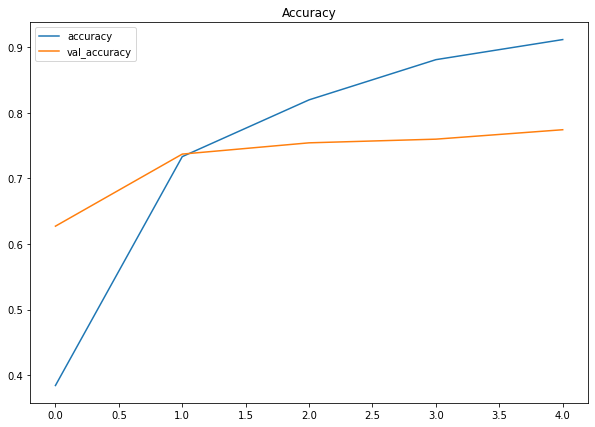

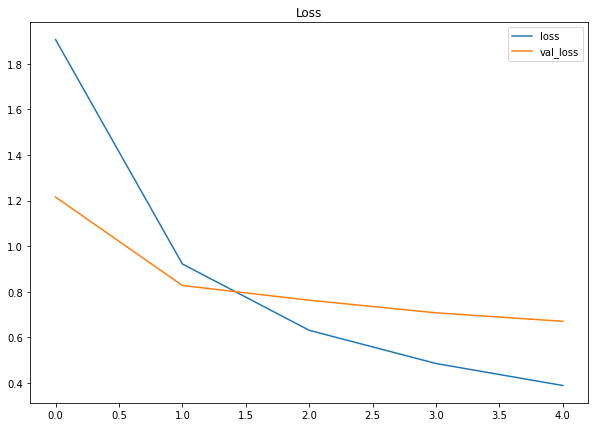

In [ ]:
plot_history(history_resnet)

### **Creating and testing Efficientnet Tesnsorflow Hub Feature Extraction Model**

In [ ]:
# Create a model
efficientnet_model = create_model(efficientnet_url, train_data_10_percent.num_classes)

In [ ]:
# Compile a model 
efficientnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [ ]:
# Fit a model
history_efficientnet = efficientnet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback("tensorflow_hub", "effcientnetb0")])

Saving Tensorflow log file to tensorflow_hub/effcientnetb0/220613-171212
Epoch 1/5
24/24 [==============================] - 26s 713ms/step - loss: 1.8214 - accuracy: 0.4587 - val_loss: 1.2699 - val_accuracy: 0.7252
Epoch 2/5
24/24 [==============================] - 15s 648ms/step - loss: 1.0410 - accuracy: 0.7613 - val_loss: 0.8604 - val_accuracy: 0.8060
Epoch 3/5
24/24 [==============================] - 15s 651ms/step - loss: 0.7517 - accuracy: 0.8307 - val_loss: 0.6948 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 15s 651ms/step - loss: 0.6055 - accuracy: 0.8693 - val_loss: 0.6108 - val_accuracy: 0.8488
Epoch 5/5
24/24 [==============================] - 15s 641ms/step - loss: 0.5127 - accuracy: 0.8907 - val_loss: 0.5578 - val_accuracy: 0.8588


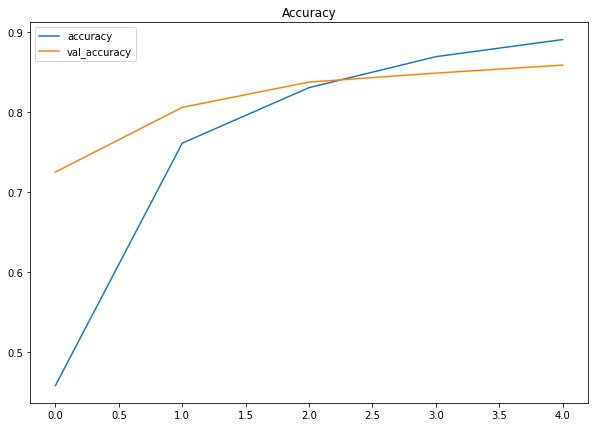

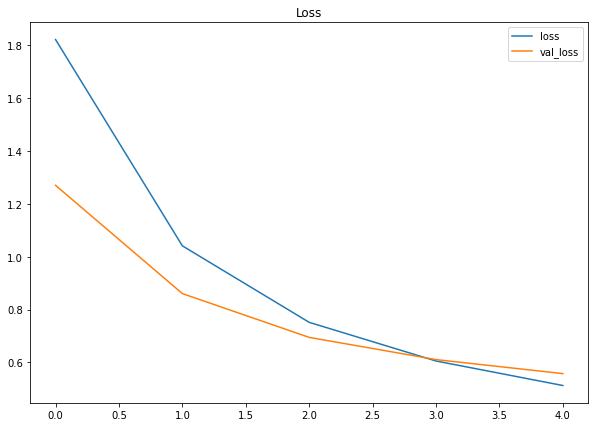

In [ ]:
# Plot efficientnet history
plot_history(history_efficientnet)

## **Comparing our model with the help of `TensorBoard`**

In [ ]:
# Upload our model to tensorboard.dev
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vs. ResNet50V2" \
 --description "Comparing our two feature extractor model from tensorflow_hub" \
 --one_shot

Our TensorBoard Experiment is publicly available here. https://tensorboard.dev/experiment/4t0PWC6bRvqzwkYMi7L7hw/

In [ ]:
# Check all of our experiment in tensorboard 
!tensorboard dev list

https://tensorboard.dev/experiment/4t0PWC6bRvqzwkYMi7L7hw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing our two feature extractor model from tensorflow_hub
	Id                   4t0PWC6bRvqzwkYMi7L7hw
	Created              2022-06-13 17:26:22 (7 minutes ago)
	Updated              2022-06-13 17:26:26 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
Total: 1 experiment(s)


In [ ]:
# Delete an uploaded experiment in tensorboard

# !tensorboard dev delete --experiment_id 4t0PWC6bRvqzwkYMi7L7hw